# Transfer Learning

In this notebook, you'll learn how to use pre-trained networks to solved challenging problems in computer vision. Specifically, you'll use networks trained on [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html). 

ImageNet is a massive dataset with over 1 million labeled images in 1000 categories. It's used to train deep neural networks using an architecture called convolutional layers. I'm not going to get into the details of convolutional networks here, but if you want to learn more about them, please [watch this](https://www.youtube.com/watch?v=2-Ol7ZB0MmU).

Once trained, these models work astonishingly well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called transfer learning. Here we'll use transfer learning to train a network that can classify our cat and dog photos with near perfect accuracy.

With `torchvision.models` you can download these pre-trained networks and use them in your applications. We'll include `models` in our imports now.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.

In [2]:
224*224

50176

In [3]:
data_dir = 'Cat_Dog_data'

# TODO: Define transforms for the training data and testing data

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

In [4]:
print("\nTraining data below")
##trainloader.size()



Training data below


In [5]:

len(train_data)


22

In [6]:
print("\n Test data below")
len(testloader)



 Test data below


1

In [7]:
len(test_data)

12

We can load in a model such as [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5). Let's print out the model architecture so we can see what's going on.

In [8]:
model = models.densenet121(pretrained=True)
model

/Users/richie/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer `(classifier): Linear(in_features=1024, out_features=1000)`. This layer was trained on the ImageNet dataset, so it won't work for our specific problem. That means we need to replace the classifier, but the features will work perfectly on their own. In general, I think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

In [9]:
# Freeze parameters so we don't backprop through them
#Total hidden in classifier = 1024+500+2 = 1526

#Freeze the downloaded pre trained part of the model
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
nclassifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = nclassifier
#Now train only the classifier, pre trained part is frozen

With our model built, we need to train the classifier. However, now we're using a **really deep** neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds. It's also possible to train on multiple GPUs, further decreasing training time.

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

In [10]:
import time

In [11]:
## for device in ['cpu', 'cuda']:
for device in ['cpu']:
    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)
    start = time.time()
    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)
        print("\n start and record time")
        print(f"\n Labels ready; Time : {(time.time() - start)/3:.3f} seconds")
        print("\n Model -move forward")
        outputs = model.forward(inputs)
        print(f"\n Time after forward pass : {(time.time() - start)/3:.3f} seconds")
        print("\nCalculating loss")
        loss = criterion(outputs, labels)
        print(f"\n Time after loss calculation : {(time.time() - start)/3:.3f} seconds")
        print("\nCalculating loss backwards")     
        loss.backward()
        print(f"\n Time after backward pass : {(time.time() - start)/3:.3f} seconds")
        optimizer.step()
        print(f"\n Time after optimiser : {(time.time() - start)/3:.3f} seconds")
        
        if ii==2:
            print("\n Value of ii is :",ii)
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")


 start and record time

 Labels ready; Time : 0.197 seconds

 Model -move forward

 Time after forward pass : 2.969 seconds

Calculating loss

 Time after loss calculation : 2.982 seconds

Calculating loss backwards

 Time after backward pass : 2.983 seconds

 Time after optimiser : 2.986 seconds
Device = cpu; Time per batch: 2.986 seconds


You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

From here, I'll let you finish training the model. The process is the same as before except now your model is much more powerful. You should get better than 95% accuracy easily.

>**Exercise:** Train a pretrained models to classify the cat and dog images. Continue with the DenseNet model, or try ResNet, it's also a good model to try out first. Make sure you are only training the classifier and the parameters for the features part are frozen.

In [12]:
# TODO: Train a model with a pre-trained network

# TODO: Train a model with a pre-trained network

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [13]:
epochs = 4
print_every = 40
steps = 0

# change to cuda
model.to('cpu')
start = time.time()
for e in range(epochs):
    running_loss = 0
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        inputs, labels = inputs.to('cpu'), labels.to('cpu')
        print(f"\n Time after moving labels in step:{steps} is : {(time.time() - start)/3:.3f} seconds")

        optimizer.zero_grad()
        print(f"\n Time after optimiser no grad : {(time.time() - start)/3:.3f} seconds")

        # Forward and backward passes
        outputs = model.forward(inputs)
        print(f"\n Time after forward pass : {(time.time() - start)/3:.3f} seconds")

        loss = criterion(outputs, labels)
        print(f"\n Time after loss based on criteria : {(time.time() - start)/3:.3f} seconds")

        loss.backward()
        print(f"\n Time after backward step: {(time.time() - start)/3:.3f} seconds")

        optimizer.step()
        print(f"\n Time after optimiser step pass : {(time.time() - start)/3:.3f} seconds")

        running_loss += loss.item()
        print(f"\n Time after calculating running loss : {(time.time() - start)/3:.3f} seconds")
        print("\n*********** End of step*********")
        if steps % print_every == 0:
            print("\nStep is :{steps}, Epoch is : {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every))
            running_loss = 0

print(f"\n Time after completing] : {(time.time() - start)/3:.3f} seconds")



 Time after moving labels in step:1 is : 0.048 seconds

 Time after optimiser no grad : 0.049 seconds

 Time after forward pass : 2.700 seconds

 Time after loss based on criteria : 2.700 seconds

 Time after backward step: 2.701 seconds

 Time after optimiser step pass : 2.703 seconds

 Time after calculating running loss : 2.703 seconds

*********** End of step*********

 Time after moving labels in step:2 is : 2.760 seconds

 Time after optimiser no grad : 2.760 seconds

 Time after forward pass : 5.417 seconds

 Time after loss based on criteria : 5.417 seconds

 Time after backward step: 5.418 seconds

 Time after optimiser step pass : 5.420 seconds

 Time after calculating running loss : 5.420 seconds

*********** End of step*********

 Time after moving labels in step:3 is : 5.477 seconds

 Time after optimiser no grad : 5.477 seconds

 Time after forward pass : 8.192 seconds

 Time after loss based on criteria : 8.192 seconds

 Time after backward step: 8.193 seconds

 Time af

In [15]:
#Accuracy
correct = 0
total = 0
startt = time.time()
print(f"\nVar initialised. Time {(time.time()-startt)/3:.3f} seconds ")
with torch.no_grad():
    print(f" \nNo grad set. Time {(time.time()-startt)/3:.3f} seconds ")
    for data in testloader:
        print(f" \nfor Data in test loader. Time {(time.time()-startt)/3:.3f} seconds ")
        images, labels = data
        print(f" \nImages and labels unzipped from data{(time.time()-startt)/3:.3f} seconds")
        outputs = model(images)
        print(f" \nout puts ser from images processed over model. Time {(time.time()-startt)/3:.3f} seconds")
        _, predicted = torch.max(outputs.data, 1)
        print(f" \nPredictions set by max prob of outputs {(time.time()-startt)/3:.3f} secoonds")
        total += labels.size(0)
        print(f" \nTotal predictions done : {total}  and time is{(time.time()-startt)/3:.3f} seconds")
        correct += (predicted == labels).sum().item()
        print(f" \nCorrect matches is counted, {correct}. Time {(time.time()-startt)/3:.3f} seconds")
print('\nAccuracy of the network on the small test images: %d %%' % (100 * correct / total))
print(f"\n**** Completed ****. Time {(time.time()-startt)/3:.3f} seconds ")


Var initialised. Time 0.000 seconds 
 
No grad set. Time 0.001 seconds 
 
for Data in test loader. Time 0.039 seconds 
 
Images and labels unzipped from data0.039 seconds
 
out puts ser from images processed over model. Time 1.485 seconds
 
Predictions set by max prob of outputs 1.485 secoonds
 
Total predictions done : 12  and time is1.485 seconds
 
Correct matches is counted, 11. Time 1.485 seconds

Accuracy of the network on the small test images: 91 %

**** Completed ****. Time 1.485 seconds 


In [30]:
from datetime import datetime
dtnow =datetime.now()
print("\nDate and time for OS check pointt filing",dtnow)
sdt_tm_now =datetime.now().strftime('"Date :" %d-%m-%y "time:" %H:%M:%S')
print("\nDate and time",dt_tm_now)


Date and time for OS check pointt filing 2018-07-20 23:09:22.581122

Date and time "Date :" 20-07-18 "time:" 23:05:52


In [17]:
#save Checkpt_CD.pt
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1

In [34]:
#torch.save(model.state_dict(), 'TransLPart8CK-PT.pth')
tll8checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers':1526,
              'details ':"TL-lesson8",
              'date_time':sdt_tm_now,
              'state_dict': model.state_dict()}



In [35]:
tll8checkpoint.keys()

dict_keys(['input_size', 'output_size', 'hidden_layers', 'details ', 'date_time', 'state_dict'])

In [37]:
tll8checkpoint.values()

dict_values([784, 10, 1526, 'TL-lesson8', '"Date :" 20-07-18 "time:" 23:09:22', OrderedDict([('features.conv0.weight', tensor([[[[ 7.8276e-02,  1.4949e-01,  1.6611e-01,  ...,  1.7676e-01,
            1.6588e-01,  1.4101e-01],
          [ 1.7546e-01,  2.4408e-01,  2.5000e-01,  ...,  2.7452e-01,
            2.5245e-01,  2.2199e-01],
          [ 1.2331e-01,  1.6441e-01,  1.4922e-01,  ...,  1.6301e-01,
            1.6191e-01,  1.4061e-01],
          ...,
          [-1.0461e-01, -1.2065e-01, -1.1969e-01,  ..., -1.1355e-01,
           -1.1181e-01, -1.1653e-01],
          [-1.4747e-01, -1.8658e-01, -1.8272e-01,  ..., -2.1694e-01,
           -2.0213e-01, -1.8302e-01],
          [-2.0729e-01, -2.7118e-01, -2.8157e-01,  ..., -2.8711e-01,
           -2.4883e-01, -2.2605e-01]],

         [[ 1.6418e-01,  2.4814e-01,  2.6538e-01,  ...,  2.7358e-01,
            2.5693e-01,  2.2483e-01],
          [ 2.4226e-01,  3.2158e-01,  3.2346e-01,  ...,  3.4569e-01,
            3.1805e-01,  2.8128e-01],
        

In [38]:
torch.save(tll8checkpoint, 'TransLearnL8CKPT.pth')

In [ ]:
## To predict

# Find Probability from result
## probs = torch.nn.functional.softmax(result[0].data, dim=1).numpy()[0]
##        classes = result[1].data.numpy()[0]




In [66]:
## First set up viz components
# Process a PIL image for use in a PyTorch model
from PIL import Image
import numpy as np

In [71]:

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img_loader = transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224), 
        transforms.ToTensor()])
    
    pil_image = Image.open(image)
    pil_image = img_loader(pil_image).float()
    
    np_image = np.array(pil_image)    
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np.transpose(np_image, (1, 2, 0)) - mean)/std    
    np_image = np.transpose(np_image, (2, 0, 1))
    np_image       
    return np_image



In [ ]:
#Prediction Plan
# Predict for 
#1) validate_cd1.jpg
#2) validate_cd2.jpg
#3) validate_cd3.jpg
#4) validate_cd4.jpg

#Edit 'to  be predicted image :' pimage in line 91

In [72]:
def pred_viz(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = np.transpose(image, (1, 2, 0))
    
    # preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

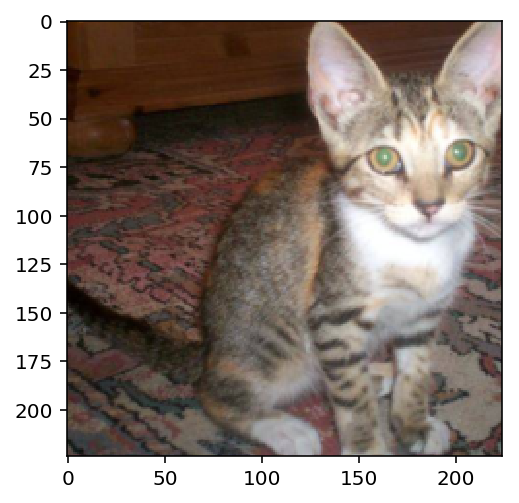

In [91]:
%matplotlib inline
pimage='validate_cd4.jpg'
pred_pimg =pred_viz(process_image(pimage))

In [92]:
#Load the to be predicted' image through same transforms as test transforms

from torch.autograd import Variable
pred_transforms = transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224), 
        transforms.ToTensor()])
    
pil_image = Image.open(pimage)
pil_image = pred_transforms(pil_image).float()
    
npimage = np.array(pil_image)    
    
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
tpimage = (np.transpose(npimage, (1, 2, 0)) - mean)/std    
tpimage = np.transpose(tpimage, (2, 0, 1))
    
tpimage = Variable(torch.FloatTensor(tpimage), requires_grad=True)
tpimage = tpimage.unsqueeze(0) # this is for VGG
 

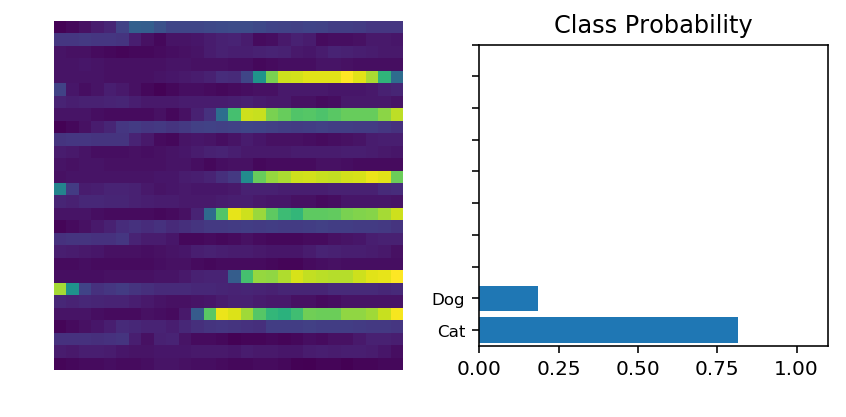

In [96]:
# TODO: Calculate the class probabilities (softmax) for img
# Turn off gradients to speed up this part

with torch.no_grad():
    logits = model.forward(tpimage)

ps = F.softmax(logits, dim=1)
#LogSoftmax

#ps = F.log_softmax(logits, dim=1)

ps = ps.data.numpy().squeeze()

fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
#pred_viz
ax1.imshow(pil_image.resize_(1, 28, 28).numpy().squeeze())
ax1.axis('off')
ax2.barh(np.arange(2), ps)
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(['Cat',
                    'Dog'], size='small');
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()